In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def calcCellPotential(vx, vy, bx, by, wv, hv, wb, hb):
    """
    Function to calculate the total potential movable area for a specific 
    cell/vertex inside a specific bin b

    Parameters:
        v_x, v_y: Center x- and y- coordinate, respectively, of this vertex
        b_x, b_y: Center x- and y- coordinate, respectively, of this bin
        wv, hv: Width and height, respectively, of this vertex
        wb, hb: Width and height, respectively, of this bin

    Return:
        pot: potential of this cell in this bin
    """
    pot = 0.0
    #Calculate p_x(b,v)
    p_x = 0.0
    p_y = 0.0
    abs_dx = np.abs(vx - bx)
    a = 4.0/((wv + 2.0*wb)*(wv + 4.0*wb))
    b = 2.0/(wb*(wv + 4.0*wb))
    if abs_dx <= (0.5*wv + wb):
        p_x = 1.0 - a*(abs_dx**2)
    elif (abs_dx >= (0.5*wv + wb)) and (abs_dx <= (0.5*wv + 2.0*wb)):
        p_x = b*((abs_dx - 0.5*wv - 2.0*wb)**2)
    else:
        p_x = 0.0
    #Calculate p_y(b,v)
    abs_dy = np.abs(vy - by)
    a = 4.0/((hv + 2.0*hb)*(hv + 4.0*hb))
    b = 2.0/(hb*(hv + 4.0*hb))
    if abs_dy <= (0.5*hv + hb):
        p_y = 1.0 - a*(abs_dy**2)
    elif (abs_dy >= (0.5*hv + hb)) and (abs_dy <= (0.5*hv + 2.0*hb)):
        p_y = b*((abs_dy - 0.5*hv - 2.0*hb)**2)
    else:
        p_y = 0.0
            
    pot = p_x*p_y
        
    return pot

def calcOvrPotential(x, w, h, bin_x, bin_y):
    """
    Function to calculate the total potential movable area for each cell
    over all bins

    Parameters:
        x: Vector of x,y coordinates of vertex/cell/cluster centers, x-coordinates first
        w: Array of vertex/cell widths. w[i] is the width of vertex/cell with center (x[i],x[i+N])
        h: Array of vertex/cell heights. h[i] is the height of vertex/cell with center (x[i],x[i+N])
        bin_x: Numpy meshgrid of bin top-left x-coordinates, with indexing='ij'
        bin_y: Numpy meshgrid of bin top-left y-coordinates, with indexing='ij'

    Return:
        ovr_pots: Array of overall potential movable area for each cell
    """
    N = x.shape[0] // 2
    Nx = bin_x.shape[0]#Grid should be square
    Ny = bin_y.shape[1]#Grid should be square
    wb = bin_x[1][0] - bin_x[0][0]
    hb = bin_y[0][1] - bin_y[0][0]
    ovr_pots = np.zeros(N, dtype=np.double)
    for k in np.arange(N):
        pot = 0.0#Potential of this cell
        for j in np.arange(Ny - 1):
            for i in np.arange(Nx - 1):
                cbin_x = bin_x[i][j] + 0.5*wb
                cbin_y = bin_y[i][j] + 0.5*hb
                if (np.abs(x[k] - cbin_x) < (0.5*w[k] + 2.0*wb)) or (np.abs(x[k+N] - cbin_y) < (0.5*h[k] + 2.0*hb)):
                    pot += calcCellPotential(x[k], x[k+N], cbin_x, cbin_y, w[k], h[k], wb, hb)
        ovr_pots[k] = pot

    return ovr_pots
        
def Db(vx, vy, bx, by, wv, hv, wb, hb, ov_pots):
    """
    Function to calculate the bin density Db contribution of
    a particular vertex v in a particular bin b

    Parameters:
        v_x, v_y: Center x- and y- coordinate, respectively, of this vertex v
        b_x, b_y: Center x- and y- coordinates, respectively, of this bin b
        wv, hv: Widths and height, respectively, of this vertex v
        wb, hb: Width and height, respectively, of this bin b
        ov_pots: Total potential movable area for this vertex v

    Return:
        Term in sum for Db for this vertex v inside this bin b
    """
    val = 0.0
    #Calculate p_x(b,v)
    p_x = 0.0
    p_y = 0.0
    abs_dx = np.abs(vx - bx)
    a = 4.0/((wv + 2.0*wb)*(wv + 4.0*wb))
    b = 2.0/(wb*(wv + 4.0*wb))
    if abs_dx <= (0.5*wv + wb):
        p_x = 1.0 - a*(abs_dx**2)
    elif (abs_dx >= (0.5*wv + wb)) and (abs_dx <= (0.5*wv + 2.0*wb)):
        p_x = b*((abs_dx - 0.5*wv - 2.0*wb)**2)
    else:
        p_x = 0.0
    #Calculate p_y(b,v)
    abs_dy = np.abs(vy - by)
    a = 4.0/((hv + 2.0*hb)*(hv + 4.0*hb))
    b = 2.0/(hb*(hv + 4.0*hb))
    if abs_dy <= (0.5*hv + hb):
        p_y = 1.0 - a*(abs_dy**2)
    elif (abs_dy >= (0.5*hv + hb)) and (abs_dy <= (0.5*hv + 2.0*hb)):
        p_y = b*((abs_dy - 0.5*hv - 2.0*hb)**2)
    else:
        p_y = 0.0
    cv = (wv*hv) / ov_pots#Normalization coefficient
    val += cv*p_x*p_y
        
    return val

def f(x, w, h, bin_x, bin_y, ovr_pots, td=0.6):
    """
    Function to calculate the sum of the Db's over all the bins

    Parameters:
        x: Array of x,y coordinates of vertex/cell/cluster centers, x-coordinates first
        w: Array of vertex/cell widths. w[i] is the width of vertex/cell with center (x[i],x[i+N])
        h: Array of vertex/cell heights. h[i] is the height of vertex/cell with center (x[i],x[i+N])
        bin_x: Numpy meshgrid of bin top-left x-coordinates, with indexing='ij'
        bin_y: Numpy meshgrid of bin top-left y-coordinates, with indexing='ij'
        ovr_pots: Array of total potential movable area for each cell over all bins
        td: Target density (0.6 by default)

    Return:
        Value of sum of the Db's over all bins
    """
    N = x.shape[0] // 2
    Nx = bin_x.shape[0]#Grid should be square
    Ny = bin_y.shape[1]#Grid should be square
    wb = bin_x[1][0] - bin_x[0][0]
    hb = bin_y[0][1] - bin_y[0][0]
    Mb = td*wb*hb#All area inside the bin can be moved - there are no pre-placed cells
    fval = 0.0
    for j in np.arange(Ny - 1):
        for i in np.arange(Nx - 1):
            #Potential movable area calculation requires all verticies
            sumDb = 0.0
            for k in np.arange(N):
                cbin_x = bin_x[i][j] + 0.5*wb
                cbin_y = bin_y[i][j] + 0.5*hb
                if (np.abs(x[k] - cbin_x) < (0.5*w[k] + 2.0*wb)) or (np.abs(x[k+N] - cbin_y) < (0.5*h[k] + 2.0*hb)):
                    sumDb += Db(x[k], x[k+N], cbin_x, cbin_y, w[k], h[k], wb, hb, ovr_pots[k])

            fval += (sumDb - Mb)**2#After computing sum over this bin, calculate penalty term for this bin
        
    return fval

def dDb(vx, vy, bx, by, wv, hv, wb, hb, ov_pots):
    """
    Function to calculate the derivative of the contribution of a specific
    vertex v to the bin density Db of a specific bin b

    Parameters:
        v_x, v_y: Center x- and y- coordinate, respectively, of
                  this vertex v
        b_x, b_y: Center x- and y- coordinates, respectively, of this bin b
        wv, hv: Widths and height, respectively, of this vertex v
        wb, hb: Width and height, respectively, of this bin b
        ov_pots: Total potential of this vertex v

    Return:
        res_x: Gradient component with respect to x of this vertex
        res_y: Gradient component with respect to y of this vertex
    """
    res_x = 0.0
    res_y = 0.0
    #Calculate p_x(b,v)
    p_x = 0.0
    p_x_dx = 0.0
    p_y = 0.0
    p_y_dy = 0.0
    abs_dx = np.abs(vx - bx)
    dx = vx - bx
    a = 4.0/((wv + 2.0*wb)*(wv + 4.0*wb))
    b = 2.0/(wb*(wv + 4.0*wb))
    if abs_dx <= (0.5*wv + wb):
        p_x = 1.0 - a*(abs_dx**2)
        p_x_dx = -2.0*a*dx
        if dx < 0:
            p_x_dx = 2.0*a*(bx - vx)
    elif (abs_dx >= (0.5*wv + wb)) and (abs_dx <= (0.5*wv + 2.0*wb)):
        p_x = b*((abs_dx - 0.5*wv - 2.0*wb)**2)
        p_x_dx = 2.0*b*(dx - 0.5*wv - 2.0*wb)
        if dx < 0:
            p_x_dx = -2.0*b*(bx - vx - 0.5*wv - 2.0*wb)
    else:
        p_x = 0.0
        p_x_dx = 0.0
    #Calculate p_y(b,v)
    abs_dy = np.abs(vy - by)
    dy = vy - by
    a = 4.0/((hv + 2.0*hb)*(hv + 4.0*hb))
    b = 2.0/(hb*(hv + 4.0*hb))
    if abs_dy <= (0.5*hv + hb):
        p_y = 1.0 - a*(abs_dy**2)
        p_y_dy = -2.0*a*dy
        if dy < 0:
            p_y_dy = 2.0*a*(by - vy)
    elif (abs_dy >= (0.5*hv + hb)) and (abs_dy <= (0.5*hv + 2.0*hb)):
        p_y = b*((abs_dy - 0.5*hv - 2.0*hb)**2)
        p_y_dy = 2.0*b*(dy - 0.5*hv - 2.0*hb)
        if dy < 0:
            p_y_dy = -2.0*b*(by - vy - 0.5*hv - 2.0*hb)
    else:
        p_y = 0.0
        p_y_dy = 0.0
    cv = (wv*hv) / ov_pots
    #Update res_x, res_y
    res_x = cv*p_x_dx*p_y
    res_y = cv*p_x*p_y_dy
        
    return res_x, res_y
    
def grad_f(x, w, h, bin_x, bin_y, ovr_pots, td=0.6):
    """
    Function to calculate the sum of the Db's over all the bins

    Parameters:
        x: Array of x,y coordinates of vertex/cell/cluster centers, x-coordinates first
        w: Array of vertex/cell widths. w[i] is the width of vertex/cell with center (x[i],x[i+N])
        h: Array of vertex/cell heights. h[i] is the height of vertex/cell with center (x[i],x[i+N])
        bin_x: Numpy meshgrid of bin top-left x-coordinates, with indexing='ij'
        bin_y: Numpy meshgrid of bin top-left y-coordinates, with indexing='ij'
        ovr_pots: Array of total potential movable area for each cell over all bins
        td: Target density (0.6 by default)

    Return:
        Value of sum of the Db's over all bins
    """
    N = x.shape[0] // 2
    del_f = np.zeros(x.shape[0], dtype=np.double)
    Nx = bin_x.shape[0]#Grid should be square
    Ny = bin_y.shape[1]#Grid should be square
    wb = bin_x[1][0] - bin_x[0][0]
    hb = bin_y[0][1] - bin_y[0][0]
    Mb = td*wb*hb#All area inside the bin can be moved - there are no pre-placed cells
    for j in np.arange(Ny - 1):
        for i in np.arange(Nx - 1):
            #Potential movable area calculation uses all verticies
            res = np.zeros(2*N, dtype=np.double)
            sumDb = 0.0
            for k in np.arange(N):
                cbin_x = bin_x[i][j] + 0.5*wb
                cbin_y = bin_y[i][j] + 0.5*hb
                if (np.abs(x[k] - cbin_x) < (0.5*w[k] + 2.0*wb)) or (np.abs(x[k+N] - cbin_y) < (0.5*h[k] + 2.0*hb)):
                    res_x, res_y = dDb(x[k], x[k+N], cbin_x, cbin_y, w[k], h[k], wb, hb, ovr_pots[k])
                    res[k] = res_x
                    res[k+N] = res_y
                    sumDb += Db(x[k], x[k+N], cbin_x, cbin_y, w[k], h[k], wb, hb, ovr_pots[k])
            
            del_f = del_f + (2.0*(sumDb - Mb)*res)
            
    return del_f

In [32]:
def derivativeChecker(m, n, max_iters=32):
    """
    m,n are matrix/vector dimensions. max_iters is max. number of iterations, default is 32
    """
    x = np.random.uniform(0.7, 4.3, n)
    w = np.random.rand(n // 2)
    hh = np.random.rand(n // 2)
    bin_x, bin_y = np.meshgrid(np.linspace(0.0,5.0,6), np.linspace(0.0,5.0,6),indexing='ij')
    v = np.random.randn(n)
    ovr_pots = calcOvrPotential(x, w, hh, bin_x, bin_y)

    max_iters = 32
    h = np.zeros(max_iters)
    err0 = np.zeros(max_iters)
    err1 = np.zeros(max_iters)

    for i in range(max_iters):
        h[i] = 2**(-i) # halve our stepsize every time
        fv = f(x + h[i]*v, w, hh, bin_x, bin_y, ovr_pots)
        T0 = f(x, w, hh, bin_x, bin_y, ovr_pots)
        T1 = T0 + h[i]*np.matmul(grad_f(x, w, hh, bin_x, bin_y, ovr_pots).transpose(), v)
        err0[i] = np.linalg.norm(fv - T0) # this error should be linear
        err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

        #Print reult as string with format ('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])
        print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

    #Plot Results
    plt.loglog(h, err0, linewidth=3)
    plt.loglog(h, err1, linewidth=3)
    plt.legend(['$||f(x) - T_0(x)||$', '$||f(x)-T_1(x)||$'], fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

h: 1.000e+00, 	 err0: 5.242e-01, 	 err1: 7.518e-01
h: 5.000e-01, 	 err0: 7.245e-01, 	 err1: 8.648e-02
h: 2.500e-01, 	 err0: 4.131e-01, 	 err1: 9.414e-02
h: 1.250e-01, 	 err0: 1.973e-01, 	 err1: 3.782e-02
h: 6.250e-02, 	 err0: 9.027e-02, 	 err1: 1.052e-02
h: 3.125e-02, 	 err0: 4.256e-02, 	 err1: 2.690e-03
h: 1.562e-02, 	 err0: 2.061e-02, 	 err1: 6.755e-04
h: 7.812e-03, 	 err0: 1.014e-02, 	 err1: 1.678e-04
h: 3.906e-03, 	 err0: 5.025e-03, 	 err1: 4.109e-05
h: 1.953e-03, 	 err0: 2.502e-03, 	 err1: 9.916e-06
h: 9.766e-04, 	 err0: 1.248e-03, 	 err1: 2.395e-06
h: 4.883e-04, 	 err0: 6.236e-04, 	 err1: 5.982e-07
h: 2.441e-04, 	 err0: 3.117e-04, 	 err1: 1.496e-07
h: 1.221e-04, 	 err0: 1.558e-04, 	 err1: 3.740e-08
h: 6.104e-05, 	 err0: 7.789e-05, 	 err1: 9.350e-09
h: 3.052e-05, 	 err0: 3.894e-05, 	 err1: 2.337e-09
h: 1.526e-05, 	 err0: 1.947e-05, 	 err1: 5.844e-10
h: 7.629e-06, 	 err0: 9.735e-06, 	 err1: 1.461e-10
h: 3.815e-06, 	 err0: 4.868e-06, 	 err1: 3.652e-11
h: 1.907e-06, 	 err0: 2.434e-06

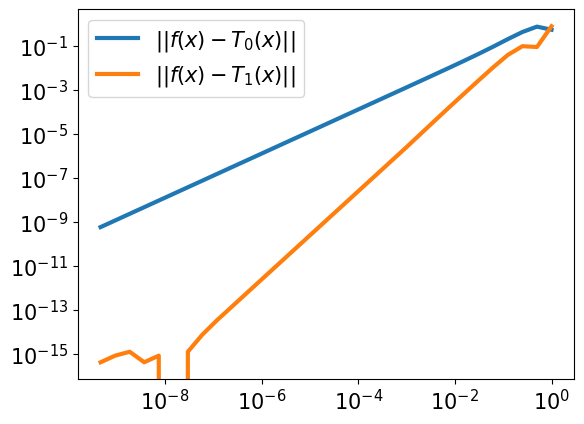

In [35]:
n = 100
derivativeChecker(n,n)